In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
np.random.seed(101101)
import scipy.optimize

import jabble.dataset
import jabble.loss
import jabble.model

import matplotlib.pyplot as plt

<h1>45 - simple data w tellurics</h1>


In [2]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [4]:
resolution = 120_000
snr        = 100
epoches    = 20

dx = jabble.dataset.delta_x(2*resolution)
transformation_value = 4000
x_grid    = np.arange(np.log(4530/transformation_value),np.log(4570/transformation_value),step=dx)

wave_grid = np.exp(x_grid) * u.Angstrom

guess_vel  = np.linspace(-60,60,epoches) * u.km/u.s
extra_vel  = np.linspace(-5,5,epoches)   * u.km/u.s
velocities = guess_vel + extra_vel
shifts     = jabble.dataset.shifts(velocities).value

means_set = [np.log(np.random.uniform(4532,4553.3,n**2)/transformation_value) for n in range(1,4)]
tellurics_set = [np.log(np.random.uniform(4532,4553.3,n**2)/transformation_value) for n in range(1,4)]

nargs = [500]
normalize = scipy.ndimage.gaussian_filter
def create_dataset(means,tell):
    
    flux = np.ones((epoches,*wave_grid.shape)) 
    print(type(shifts),type(dx),type(x_grid))
    for i,mean in enumerate(means):
        flux -= 0.7 * gaussian(np.repeat((x_grid)[np.newaxis,:],epoches,axis=0),np.repeat((mean + shifts)[:,np.newaxis],wave_grid.shape[0],axis=1),dx)
        flux -= 0.5 * gaussian(np.repeat((x_grid)[np.newaxis,:],epoches,axis=0),np.repeat((np.array([tell[i]]))[:,np.newaxis],wave_grid.shape[0],axis=1),dx)
        
    # add noise
    for j in range(flux.shape[0]):
        for k in range(flux.shape[1]):
            flux[j,k] -= np.random.normal(0.0,np.abs(flux[j,k]/snr))
    ferr = flux/snr

    
    dataset = jabble.dataset.Dataset.from_flux(np.repeat((wave_grid)[np.newaxis,:],epoches,axis=0),flux,ferr,mask=np.ones(flux.shape),normalize=normalize,nargs=nargs)
    return dataset

In [5]:
datasets = [create_dataset(mean,tell) for mean,tell in zip(means_set,tellurics_set)]

<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>


/home/mdd423/wobble_jax/notebooks/../jabble/dataset.py:122: RuntimeWarning: invalid value encountered in log
  ys = np.log(flux_interp/flux_norm)


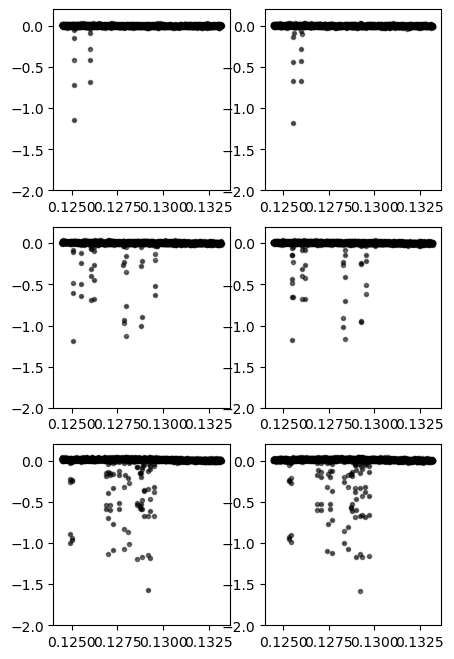

In [6]:
plt_inds = epoches
xpmin = np.log(4550)
xpmax = np.log(4560)
fig, axes = plt.subplots(len(datasets),2,figsize=(5,8))
for i,dataset in enumerate(datasets):
    axes[i,0].errorbar(dataset.xs[0,:],dataset.ys[0,:],dataset.yerr[0,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    axes[i,1].errorbar(dataset.xs[-1,:],dataset.ys[-1,:],dataset.yerr[-1,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

#     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    axes[i,0].set_ylim(-2,0.2)
    axes[i,1].set_ylim(-2,0.2)
plt.show() 

In [7]:
type(dataset.xs), type(dataset.ys), type(dataset.mask), type(dataset.yivar)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [8]:
loss = jabble.loss.ChiSquare()
init_vels   = guess_vel
init_shifts = jabble.dataset.shifts(init_vels)

In [9]:
x_grid.shape

(2110,)

In [10]:
import jax

In [11]:
from collections import namedtuple

In [12]:
from jaxopt import GaussNewton
import jax.numpy as jnp

class MyModel(jabble.model.CompositeModel):
    def grad_descent(self,loss,data,verbose=False,options={},save_history=False,save_loss=False,*args):
        # Fits the Model
        self.save_history = save_history
        self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)
        def val_gradient_function(p,*args):
            val, grad = func_grad(p,*args)
            self.func_evals.append(val)
            if verbose:
                print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

            if self.save_history:
                self.history.append(np.array(p))

            if self.save_loss:
                initialize = loss(p,data,0,self)
                tmp        = np.zeros((data.ys.shape[0],*initialize.shape))
                tmp[0,...] = initialize
                for i in range(1,data.ys.shape[0]):
                    tmp[i,...] = loss(p,data,i,self)
                self.loss_history.append(tmp)

            return np.array(val,dtype='f8'),np.array(grad,dtype='f8')

        res = grad_descent(val_gradient_function, self.get_parameters(), data, self, options=options)
        self.results.append(res)
        self.unpack(res.x)
        return res
    
    def gaussnewton(self,data,verbose=False,save_history=False,save_loss=False,*args):
        # Fits the Model
        self.save_history = save_history
        self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])
        def chi_1(p):
            residual = jnp.zeros(data.xs.shape)
            for i in range(data.xs.shape[0]):
                
                residual = residual.at[i,:].set((data.ys[i,:] - self(p,data.xs[i,:],i)) * data.yivar[i,:])
            return residual
        
        
#         func_grad = jax.value_and_grad(chi_1, argnums=0)
#         def val_gradient_function(p,*args):
#             val, grad = func_grad(p,*args)
#             self.func_evals.append(val)
#             if verbose:
#                 print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

#             if self.save_history:
#                 self.history.append(np.array(p))

        gn = GaussNewton(residual_fun=chi_1)
        gn_sol = gn.run(self.get_parameters())
        
        self.results.append(gn_sol)
        self.unpack(gn_sol.params)
        return gn_sol
    
    def new_lbfgsb(self,loss,data,verbose=False,save_history=False,save_loss=False,**options):
        # Fits the Model
#         self.save_history = save_history
#         self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)
        def val_gradient_function(p,*args):
            val, grad = func_grad(p,*args)
            self.func_evals.append(val)
            if verbose:
                print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

            if self.save_history:
                self.history.append(np.array(p))

            if self.save_loss:
                initialize = loss(p,data,0,self)
                tmp        = np.zeros((data.ys.shape[0],*initialize.shape))
                tmp[0,...] = initialize
                for i in range(1,data.ys.shape[0]):
                    tmp[i,...] = loss(p,data,i,self)
                self.loss_history.append(tmp)

            return np.array(val,dtype='f8'),np.array(grad,dtype='f8')

        x, f, d = scipy.optimize.fmin_l_bfgs_b(val_gradient_function, self.get_parameters(), None, (data, self))
        self.results.append(d)
        self.unpack(x)
        return d

In [13]:
dataset.xs.shape

(20, 2110)

In [14]:
class MyShiftingModel(jabble.model.ShiftingModel):
    def grid_search(self,grid,loss,model,data,epoches=None):
        if epoches is None:
            epoches = slice(0,self.n)
        # put all submodels in fixed mode except the shiftingmodel
        # to be searched then take loss of each epoch
        # that we hand the loss a slice of the shift array
        # since at __call__ itll on take the shift_grid[i,j] element
        model.fix()
        # index is the index of the submodel to grid search this is redundant
        self.fit(epoches=epoches)
        if isinstance(model,jabble.model.ContainerModel):
            model.get_parameters()
        # this is called because this resets the parameters per model
        # array
        # I want to have this be done when a submodel is put into fix or fix mode
        loss_arr = np.empty(grid.shape)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                # print(shift_grid[:,j].shape)
                out = loss(grid[:,j],data,i,model)
#                 print(out.shape)
                loss_arr[i,j] = np.sum(out)
        return loss_arr

In [15]:
vel_padding = 100 * u.km/u.s
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
model_set = [[MyModel([MyShiftingModel(init_shifts),jabble.model.BSplineModel(model_grid,i)]) for i in range(1,4)] for j in range(1,4)]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [16]:
def grad_descent(val_grad,p,data,model,options):
    
    res = namedtuple('Results', ['x','jac'])
    iteration = 1
    grad = [1e99]
    
#     anneal = 1./np.e
    while np.inner(grad,grad) > options['condition']:
        val, grad = val_grad(p,data,model)
        delta_x   = grad*options['size']#*anneal**(iteration-1)
        print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))
        p         -= delta_x
        iteration += 1
        if options['maxiter'] < iteration:
            print('maxiter reached')
            break
        
    res.x = p
    res.jac = grad
    return res

In [17]:
def train_cycle(model,dataset,loss):
    n_cycles = 3

    options1 = {'pgtol': 0.0}
    options2 = {'pgtol': 0.0}
    for iii in range(n_cycles):
        # Fitting Round 1
        print('fitting round {} 1'.format(iii))
        model.fix()
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options1)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
        # Fitting Round 3
        print('fitting round {} 2'.format(iii))
        model.fix()
        model.fit(0)
        res1 = model.new_lbfgsb(loss,dataset,options=options2)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
    return model

In [ ]:
for i in range(3):
    for j in range(3):
        print('pval: ',model_set[i][j][1].p_val,'ds: ',i)
        
#         print(j)
        model_set[i][j] = train_cycle(model_set[i][j],datasets[i],loss)

pval:  1 ds:  0
fitting round 0 1
0 12
fitting round 0 2
0 7
fitting round 1 1
2 31
ABNORMAL_TERMINATION_IN_LNSRCH
fitting round 1 2
0 7
fitting round 2 1
0 33
fitting round 2 2
0 10
pval:  2 ds:  0
fitting round 0 1


In [ ]:
fig,ax = plt.subplots(len(model_set),len(datasets),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

for i in range(len(model_set)):
    for j in range(len(datasets)):
        estimate_vel = jabble.dataset.velocities(model_set[i][j][0][0].p)
        dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
        ax[i][j].plot(epoch_range,dv,'.r',label='estimation')
        ax[i][j].set_title('p: {}, lines: {}'.format(model_set[i][j][1].p_val,len(means_set[i])))
        # ax.set_ylim(-5.5e3,5.5e3)
        # for epoch in epoch_range:
        #     constant = 1e-5
        #     ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1].jac[epoch])

        # twin_ax = ax.twinx()
        # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
        # twin_ax.set_ylim(-1e9,1e9)
# plt.ylabel('dv [m/s]')
# plt.xlabel('epoches')
# plt.legend()
plt.savefig(os.path.join(out_dir,'45-dv.png'))
plt.show()

In [ ]:
def norm_func(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low/y

In [ ]:
out_dir

In [ ]:
lmin = 4530/transformation_value
lmax = 4550/transformation_value
x_window = np.log(4550/transformation_value) - np.log(4549/transformation_value)


lrange = np.arange(lmin,lmax,3)
plt_unit = u.Angstrom
plt_epoch = 10
fig, axes = plt.subplots(len(model_set),len(datasets),figsize=(10,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
for i in range(len(model_set)):
    for j in range(len(datasets)):
        
        model_set[i][j].fix()
        axes[i, j].errorbar(datasets[i].xs[plt_epoch,:],datasets[i].ys[plt_epoch,:],\
                                 datasets[i].yerr[plt_epoch,:],fmt='.k',\
                                 elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
    #     axes[j%yax, j//yax].plot(stellar_model[1].xs+stellar_model[0].p[j],\
    #                          stellar_model[1].p,\
    #                          '.r',linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
        xplot = np.linspace(np.log(lmin),np.log(lmax),5000)
        axes[i,j].plot(xplot,model_set[i][j]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

        axes[i,j].set_ylim(-2,1)
#         axes[i,j].set_yticks([])
        axes[i,j].set_xticks(np.log(lrange))
        axes[i,j].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes[i,j].set_xlim(np.mean(means_set[i][0])-x_window+model_set[i][j][0].p[plt_epoch],np.mean(means_set[i][0])+x_window+model_set[i][j][0].p[plt_epoch])

        res_ax = axes[i,j].twinx()
    #     res_ax.set_yticks([])
    #     res_ax = axes[j%2,j//2].twinx()
    #     residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
    #     res_ax.step(dataset.xs[j,:],residual,where='mid',alpha=0.3,label='residual')
        res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
                    model_set[i][j].results[-2]['grad'][:],\
                    where='mid',alpha=0.4,label='residual',zorder=-1)

# stellar_model[0].p.shape[0]
#     res_ax.set_xlim(xpmin,xpmax)
#     res_ax.set_ylim(-2e4,1e5)
    
plt.savefig(os.path.join(out_dir,'45-allplots.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
for res in stellar_model.results:
    print(res)
#     print(res['hess_inv'])

In [ ]:
print(res)